In [1]:
from IPython.display import display, Markdown

with open('README.md', 'r') as fh:
    content = fh.read()

display(Markdown(content))

# *enviro*

## Energy data Visualization Routine

###### A tool for creating visuals from historical energy data (e.g. the EIA monthly energy review).
 
This tool is designed to provide insightful, aesthetic and more flexible visualizations of the Energy Information Administration (EIA) monthly energy review datasets. The datasets contain information about the sources of energy Americans have relied on for power since the middle of the 20th century. The datasets begin in 1949 with annual energy production, consumption, import, and export values, and extend up until the present. Monthly energy datapoints are reported starting in 1973.

The basic energy sources are reported in the following groups:  

###### Fossil Fuels
* Coal
* Natural Gas
* Petroleum

###### Renewables
* Wind
* Solar
* Hydroelectric
* Geothermal
* Biomass

###### Nuclear
* Fission

The data is published monthly on the [EIA's website](https://www.eia.gov/totalenergy/data/monthly/), and as of July 5th, 2017 records were provided up through March 2017.

All reported values are in units of quadrillion british thermal units (1.0E15 btu). Be aware that the datasets may provide [more precision](https://www.eia.gov/totalenergy/data/monthly/dataunits.php) than is published in the PDF reports.

--------------------------------------------------------------

Outside dependencies are numpy and glob.

--------------------------------------------------------------


## Structure

This toolkit is designed so that a user can specify any of the reported energy sources and simply construct visuals to demonstrate trends in that energy's usage over time, as well make comparisons between the use of energy sources over time. 

To accomplish this goal, there are two classes that are defined: an energy class (EClass) and a visualization class (VClass). 

#### EClass
The EClass collects information from the specified energy source. Within this class will be methods for retrieving data according to specific attributes of the energy source, such as energy consumed from that source per decade, per year, or all years in which more than a certain amount of energy was consumed from that source. Use this class to extract and return pure data from the dataset.

#### VClass
The VClass takes one or more EClasses as input upon initialization. The VClass will then feature methods to visualize the data, including the ability to make comparisons if more than one EClass is given. These visualizations could include histograms, line graphs, pie charts and animations.

--------------------------------------------------------------

Upload the dataset (a CSV) in the form of a numpy array.

In [ ]:
# %load utils/load_data.py
"""
Utilities for loading EIA Monthly Energy Review (MER) datasets.

Functions
---------
load_dataset
    Loads an EIA MER dataset from a csv file.
get_default
    Finds the default MER dataset csv file.
find_most_recent
    Finds the most MER dataset csv file.
"""
import numpy as np
import os
from glob import glob

def load_dataset(dataset_date='default',dataset_type=None):
    """
    Loads an EIA MER dataset from a csv file.
    
    Parameters
    ----------
    dataset_date : str
        The date identifier of the dataset; 'default' and 'newest' are current options
        (specific dataset dates to be added).
    dataset_type : str
        The type of dataset to be selected; can be either 'production', 'consumption', 
        'import', or 'export' (set as None for default dataset) 
    
    Returns
    -------
    ndarray
        Data from the EIA MER dataset.
    """
    # Get the dataset corresponding to the date identifier given
    EIA_MER_DATA_PATH = os.getcwd()+'/data/'
    if dataset_date == 'default': EIA_MER_DATA_FILE = get_default()
    elif dataset_date == 'newest': EIA_MER_DATA_FILE = get_newest(dataset_type)
    else: raise ValueError('"Default" is the only dataset date identifier currently implemented.')

    # Process the dataset to allow conversion to float
    data_string_array = np.genfromtxt(EIA_MER_DATA_PATH+EIA_MER_DATA_FILE,dtype=str,delimiter=',')[1:,1:4]
    data_string_array = np.char.replace(data_string_array,'"','')
    data_string_array = np.char.replace(data_string_array,'Not Available','nan')
    data_float_array = data_string_array.astype(float)
    return data_float_array

def get_default():
    """
    Gets the filename of the default dataset from your filesystem.
    
    Returns
    -------
    str
        The filename of the default dataset.
    """
    return 'EIA_MER.csv'


def get_newest(dataset_type):
    """
    Gets the filename of the most recent dataset from your filesystem.
    
    Returns
    -------
    str
        The filename of the most recently downloaded dataset.
    """
    labeldict = {'production':'prod', 'consumption':'cons', 'import':'imp', 'export':'exp'}
    label = labeldict[dataset_type]

    directories = [directory.split('/')[1] for directory in glob('data/*/')]
    dirdates = np.array([int(directory[-6:]) for directory in directories])
    newestdir = directories[np.argmax(dirdates)]
    basename = newestdir.split('/')[-1]
    typelist = basename.split('_')
    typelist.insert(2,label)
    typename = '_'.join(typelist)
    newestdatafile = newestdir+'/'+typename+'.csv'
    return newestdatafile




In [ ]:
# %load utils/eia_codes.py
"""
Utilities for converting user inputs into EIA dataset codes.

Functions
---------
name_to_code
    Converts energy names into EIA energy codes.
date_to_code
    Converts date string into EIA data code.
"""


def name_to_code(name):
    """
    Convert an energy source name to its corresponding EIA dataset numeric code.
    
    Parameters
    ----------
    name : str
        The name of an EIA energy or energy group.
        
    Returns
    -------
    name_code : int
        The code corresponding to the energy source provided.
    """
    key_name = name.lower()
    Ecodes = {'coal':1,
              'natural gas':2,
              'petroleum':3,
              'fossil fuel':4,
              'nuclear':5,
              'hydro':6,
              'geothermal':7,
              'solar':8,
              'wind':9,
              'biomass':10,
              'renewable':11,
              'primary':12}
        
    if key_name not in Ecodes:
        raise KeyError('Key "{}" was not found in the EIA dataset; see documentation for implemented energy sources.'.format(key_name))
    else:
        name_code = Ecodes[key_name]
    return name_code


def date_to_code(date):
    """
    Convert an input date to its corresponding EIA dataset numeric date code.
    
    Parameters
    ----------
    date : str
        A date, given in the format 'YYYYMM', 'YYYY-MM', or 'MM-YYYY'. 
        Dashes ("-") can be substituted for periods ("."), underscores ("_"), or forward slashes ("/").
        
    Returns
    -------
    date_code : int
        The code corresponding to the energy source provided.
    """
    bad_format_err_msg = 'Date "{}" was not given in an acceptable format; try formatting date as "YYYYMM".'.format(date)
    acceptable_separators = ["-",".","/","_"]
    
    # Convert date to code
    if len(date) == 6:
        date_code_string = date
    elif len(date) == 7:
        if date[4] in acceptable_separators:
            date_code_string = date.replace(date[4],'')
        elif date[2] in acceptable_separators:
            date_code_string = (date[3:]+date[:3]).replace(date[2],'')
    else:
        raise ValueError(bad_format_err_msg)
        
    # Check reasonability of date provided
    try:
        year = int(float(date_code_string[0:4]))
        month = int(float(date_code_string[4:6]))
        if year < 1900 or year > 3000:
            raise ValueError('No data exists for this time period.')
        if month > 13:  # 13 denotes full year sum
            raise ValueError('A month must be given as a number 1-12')
        date_code = int(float(date_code_string))
    except:
        raise ValueError(bad_format_err_msg)
    return date_code


### Energy Class

In [ ]:
# %load main/eclass.py
import numpy as np
from utils.load_data import load_dataset
from utils.eia_codes import name_to_code, date_to_code


class EClass:
    
    """
    Collect energy consumption data for a user-defined energy source.
    
    Retrieves data from the specified energy source according to specific 
    attributes, such as energy consumed per decade, per year, or all years in 
    which more than a certain amount of energy was consumed from that source.
    Use this class to extract and return pure data from the dataset.
    """
    
    def __init__(self,energy_source,dataset=np.empty(0)):
        """
        Receive energy source (as numeric code) and collect corresponding data.
        
        Parameters
        ----------
        Ecode : int
            The energy source to be pulled from the dataset.
        dataset : array_like, optional
            The dataset from which to pull information. Must be three ordered columns
            –date, energy quantity, and energy code–with no headings. If omitted, use the
            default dataset.
        """
        # Use default dataset if dataset argument is omitted
        if np.size(dataset) == 0:
            dataset = load_dataset()
       
         # Determine Ecode from energy source name
        Ecode = name_to_code(energy_source)

        # Eliminate 'nan' data from source
        dataset = dataset[np.logical_not(np.isnan(dataset[:,1]))]
        
        # Isolate this energy's data from source, and remove (now superfluous) Ecode
        self.data = dataset[dataset[:,2]==Ecode,:2]
        
        # Get the oldest and newest datapoint dates for this energy" 
        self.idate = int(min(self.data[:,0]))
        self.fdate = int(max(self.data[:,0]))
        
        self.freq_errmsg = '"{}" is not a frequency compatible with this dataset; see documentation for permissible frequencies.' 
        self.extr_errmsg = '"{}" is not a recognized input for an extrema; try "max" or "min"' 

    def _daterange(self,start_date,end_date):
        """
        Resize the dataset to cover only the date range specified.
        
        Parameters
        ----------
        start_date, end_date : int
            The dataset start/end dates (both inclusive) as integers (YYYYMM).
            
        Returns
        -------
        bound_data : ndarray
            A 2 column array corresponding to the specified date range.
        """
        # Use dataset default dates unless otherwise specified by the user
        start_date = self.idate if start_date == None else date_to_code(str(start_date))
        end_date = self.fdate if end_date == None else date_to_code(str(end_date))
       
        # Adjust dataset boundaries 
        half_bounded_data = self.data[self.data[:,0] >= start_date]
        bounded_data = half_bounded_data[half_bounded_data[:,0] <= end_date]
        return bounded_data
     
    def _monthlydata(self,data):
        """
        Limit the data to consider only monthly totals.

        Parameters
        ----------
        data : ndarray
            A 2 column array with data to be filtered according to monthly totals.

        Returns
        -------
        monthly_data : ndarray
            A 2 column array corresponding to only the monthly totals.
        """
        # Remove dates where the fifth and sixth digits of the date code are not in 01-12
        month_codes = np.array([int(float(str(date_code)[4:6])) for date_code in data[:,0]])
        monthly_data = data[month_codes!=13]
        return monthly_data
     
    def _yearlydata(self,data):
        """
        Limit the data to consider only yearly totals.

        Parameters
        ----------
        data : ndarray
            A 2 column array with data to be filtered according to yearly totals.

        Returns
        -------
        yearly_data : ndarray
            A 2 column array corresponding to only the yearly totals.
        """
        # Remove dates where the fifth and sixth digits of the date code are not 13 (denoting yearly total)
        month_codes = np.array([int(float(str(date_code)[4:6])) for date_code in data[:,0]])
        yearly_data = data[month_codes==13]
        return yearly_data
       
    def totals(self,freq='yearly',start_date=None,end_date=None,):
        """
        Get the energy consumption totals over a given period.
        
        Parameters
        ----------
        freq : str
            The frequency for gathering totals ('monthly','yearly',or 'cumulative').
        start_date, end_date : str
            The user specified dataset starting and ending dates (both inclusive); 
            acceptable formats are 'YYYYMM', 'YYYY-MM', or 'MM-YYYY'. Dashes ("-") can 
            be substituted for periods ("."), underscores ("_"), or forward slashes ("/").
            
        Returns
        -------
        totals_array : ndarray
            A 2 column array giving dates at the given frequency and corresponding totals.
        """
        freq = freq.lower()

        # Bound data by start and end dates
        totals_data = self._daterange(start_date,end_date)
        
        # Extract data according to frequency
        if freq == 'monthly':
            totals_data = self._monthlydata(totals_data)
        elif freq == 'yearly':
            totals_data = self._yearlydata(totals_data)
        elif freq == 'cumulative':
            # Create a numpy array (1x2) of the energy source's cumulative total
            month_codes = np.array([int(float(str(date_code)[4:6])) for date_code in totals_data[:,0]])
            date_indices_to_sum = (month_codes == 13)
            for i in range(len(date_indices_to_sum)):
                if date_indices_to_sum[-i-1] == False:
                    date_indices_to_sum[-i-1] = True
                else: break
            totals_data = np.array([np.sum(self.data[date_indices_to_sum],axis=0)])
            totals_data[-1,0] = self.data[-1,0]
        else:
            raise ValueError(self.freq_errmsg.format(freq))
        totals_array = totals_data
        return totals_array
        
    def extrema(self,extremum,freq,start_date=None,end_date=None):
        """
        Get the maximum/minimum energy consumed over a given period.
        
        Parameters
        ----------
        extremum : str
            The exteme value to be found ('max' or 'min).
        freq : str
            The frequency for checking extrema ('monthly' or 'yearly').
        start_date, end_date : str
            The user specified dataset starting and ending dates (both inclusive); 
            acceptable formats are 'YYYYMM', 'YYYY-MM', or 'MM-YYYY'. Dashes ("-") can 
            be substituted for periods ("."), underscores ("_"), or forward slashes ("/").
        
        Returns
        -------
        extremum_array : ndarray
            A 1x2 array giving the extremum values specified (column 2) and the date of
            occurrence for that value (column 1).
        """
        # Bound data by start and end dates
        extrema_data = self._daterange(start_date,end_date)

        # Extract data according to frequency
        if freq == 'monthly':
            extremum_data = self._monthlydata(extrema_data)
        elif freq == 'yearly':
            extremum_data = self._yearlydata(extrema_data)
        else:
            raise ValueError(self.freq_errmsg.format(freq))
        
        # Select max or min
        extremum = extremum.lower()[:3]
        if extremum == 'max':
            extremum_array = np.array([extremum_data[np.argmax(extremum_data[:,1])]])
        elif extremum == 'min':
            extremum_array = np.array([extremum_data[np.argmin(extremum_data[:,1])]])
        else:
            raise ValueError(self.extr_errmsg.format(extremum))
        return extremum_array

    #def more_than(self,amount,start_date,end_date,interval):
        """
        Get data for time interval where more than the given amount of energy was consumed.
        
        Parameters
        ----------
        amount: float
            The lower boundary (exclusive) for which data may be included in the dataset.
        start_date, end_date : str
            The user specified dataset starting and ending dates (both inclusive); 
            acceptable formats are 'YYYYMM', 'YYYY-MM', or 'MM-YYYY'. Dashes ("-") can 
            be substituted for periods ("."), underscores ("_"), or forward slashes ("/").
        interval : str
            The time intervals considered for extrema comparison ('yearly',or 'monthly').
        """
        
    
    
    """
    Additonal potential options to add:
        - average yearly energy consumed
        - average seasonal energy consumed
        - consolidate date range selection and monthly/yearly/cumulative selection into a _formatdata method
    """
 



In [ ]:
# %load tests/test_eclass.py
import numpy as np
from main.eclass import EClass


class TestEClass:
     
    def test_Preprocessing(self):
        testdata = np.array([[195001,1,5],
                             [195101,None,5],
                             [195201,1,5],
                             [195201,1,6]],
                            float)
        # eliminate nan, isolate energy, remove ecode column
        preprocdata = np.array([[195001,1],
                                [195201,1]],
                               float)
        EC = EClass('nuclear',testdata)
        assert np.array_equal(EC.data,preprocdata)

    def test_FindingInitialDate(self):
        testdata = np.array([[195001,1,5],
                             [195101,1,5]],
                            float)
        EC = EClass('nuclear',testdata)
        assert EC.idate == 195001
    
    def test_FindingFinalDate(self):
        testdata = np.array([[195001,1,5],
                             [195101,1,5]],
                            float)
        EC = EClass('nuclear',testdata)
        assert EC.fdate == 195101
     
    def test_daterange_BoundingInputDates(self):
        testdata = np.array([[195010,1,5],
                             [195011,2,5],
                             [195012,2,5],
                             [195013,7,5],
                             [195101,2,5],
                             [195102,1,5],
                             [195103,1,5]],
                            float)
        boundedmonths = np.array([[195011,2],
                                  [195012,2],
                                  [195013,7],
                                  [195101,2],
                                  [195102,1]],
                                 float)
        EC = EClass('nuclear',testdata)
        assert np.array_equal(EC._daterange(195011,195102),boundedmonths)
    
    def test_daterange_BoundingDefaultDates(self):
        testdata = np.array([[195010,1,5],
                             [195011,2,5],
                             [195012,2,5],
                             [195013,7,5],
                             [195101,2,5],
                             [195102,1,5],
                             [195103,1,5]],
                            float)
        EC = EClass('nuclear',testdata)
        assert np.array_equal(EC._daterange(None,None),testdata[:,0:2])
      
    def test_monthlydata_FindingDataByMonth(self):
        testdata = np.array([[195013,2,5],
                             [195101,1,5],
                             [195102,1,5],
                             [195113,3,5]],
                            float)
        monthlydata = np.array([[195101,1],
                                  [195102,1]],
                                 float)
        EC = EClass('nuclear',testdata)
        testdata_bounded = EC._daterange(None,None)
        assert np.array_equal(EC._monthlydata(testdata_bounded),monthlydata)
        
    def test_yearlydata_FindingDataByYear(self):
        testdata = np.array([[195013,2,5],
                             [195101,1,5],
                             [195102,1,5],
                             [195113,3,5]],
                            float)
        yearlydata = np.array([[195013,2],
                                 [195113,3]],
                                float)
        EC = EClass('nuclear',testdata)
        testdata_bounded = EC._daterange(None,None)
        assert np.array_equal(EC._yearlydata(testdata_bounded),yearlydata)
        
    def test_totals_FindingMonthlyTotals(self):
        testdata = np.array([[195013,2,5],
                             [195101,1,5],
                             [195102,1,5],
                             [195113,3,5]],
                            float)
        monthlytotals = np.array([[195101,1],
                                  [195102,1]],
                                 float)
        EC = EClass('nuclear',testdata)
        assert np.array_equal(EC.totals(freq='monthly'),monthlytotals)
        
    def test_totals_FindingYearlyTotals(self):
        testdata = np.array([[195013,2,5],
                             [195101,1,5],
                             [195102,1,5],
                             [195113,3,5]],
                            float)
        yearlytotals = np.array([[195013,2],
                                 [195113,3]],
                                float)
        EC = EClass('nuclear',testdata)
        assert np.array_equal(EC.totals(freq='yearly'),yearlytotals)

    def test_totals_FindingCumulativeTotal(self):
        testdata = np.array([[195013,2,5],
                             [195101,1,5],
                             [195113,3,5],
                             [195201,1,5]],
                            float)
        cumulativetotal = np.array([[195201,6]],
                                   float)
        EC = EClass('nuclear',testdata)
        assert np.array_equal(EC.totals(freq='cumulative'),cumulativetotal)

    def test_extrema_FindingMonthlyMaximum(self):
        testdata = np.array([[195013,6,5],
                             [195101,1,5],
                             [195102,4,5],
                             [195113,5,5],
                             [195201,1,5]],
                            float)
        monthlymax = np.array([[195102,4]],
                              float)
        EC = EClass('nuclear',testdata)
        assert np.array_equal(EC.extrema('max','monthly'),monthlymax)

    def test_extrema_FindingMonthlyMinimum(self):
        testdata = np.array([[195013,6,5],
                             [195101,1,5],
                             [195102,4,5],
                             [195113,5,5],
                             [195201,2,5]],
                            float)
        monthlymin = np.array([[195101,1]],
                              float)
        EC = EClass('nuclear',testdata)
        assert np.array_equal(EC.extrema('min','monthly'),monthlymin)

    def test_extrema_FindingYearlyMinimum(self):
        testdata = np.array([[195013,7,5],
                             [195101,2,5],
                             [195102,3,5],
                             [195113,5,5],
                             [195201,1,5]],
                            float)
        yearlymin = np.array([[195113,5]],
                              float)
        EC = EClass('nuclear',testdata)
        assert np.array_equal(EC.extrema('min','yearly'),yearlymin)

    def test_extrema_FindingYearlyMaximum(self):
        testdata = np.array([[195013,4,5],
                             [195101,2,5],
                             [195102,3,5],
                             [195113,5,5],
                             [195201,1,5]],
                            float)
        yearlymax = np.array([[195113,5]],
                              float)
        EC = EClass('nuclear',testdata)
        assert np.array_equal(EC.extrema('max','yearly'),yearlymax)




### Visualization Class

In [ ]:
# Contents of vclass.py module


class VClass:
    
    """
    Create visuals based on energy data.
    
    Takes one or more EClasses as input upon initialization, providing
    methods to visualize the data (including the ability to make comparisons
    across energy sources if more than one EClass is given. Visualizations 
    include histograms, line graphs, pie charts, and animations.   
    """
    
    def __init__(self,*energies):
        """
        Receive energy source(s) and assemble the appropriate class(es).
        
        Parameters
        ----------
        *energies : str
            The energy source(s) to be visualized.
        """
                
        # Convert energy name to code
        Eset = set()
        for Ename in args:
            Ecode = name_to_code(Ename)
            Eset.add(Ecode)    
        # Assemble energy classes
        self.EClasses = [EClass(Ecode) for Ecode in Eset]
        
    def select_data(self,interval,method,amount=None):
        """
        Filter data according to user requirements.
        
        Parameters
        ----------
        interval : str
            The filter applied by the user to select a dataset timeframe
            (i.e. `monthly`,`yearly`, or `lifetime`); `lifetime` can only be used
            with method-keyword `totals`.
        method : str
            The filter applied by the user to gather data attributes 
            (i.e. `totals`,`max`,`more_than`).
        amount : float
            The filter applied by the user specifying a lower bound for energy consumption.
        """
    
        if method == 'total':
            if interval == 'lifetime':
                for EClass in self.EClasses:
                    pass
                    
        
        

In [11]:
# %load test_eia_codes.py
from eia_codes import name_to_code as ntc
from eia_codes import date_to_code as dtc

class TestNTC:
    
    def test_ntc_ConvertingName(self):
        assert ntc('coal') == 1
    
    def test_ntc_IgnoringCase(self):
        assert ntc('Renewable') == 11

class TestDTC:

    def test_dtc_ReadingFormat1(self):
        assert dtc('20170812') == float(20170812)

    def test_dtc_ReadingFormat2(self):
        assert dtc('2017-08-12') == float(20170812)
        
    def test_dtc_ReadingFormat3(self):
        assert dtc('08-12-2017') == float(20170812)

    def test_dtc_ReadingFormat4(self):
        assert dtc('08/12/2017') == float(20170812)



In [ ]:
# Contents of plot_graphs.py module
from matplotlib import pyplot as plt


def line_graph(ax,indep,*dep):
    pass
    
    
def bar_chart(ax,indep,*dep):
    pass
    
    
def pie_chart(ax,indep,*dep):
    pass
    
    
def style(ax,title,xlabel,ylabel,ticks=None,):
    pass



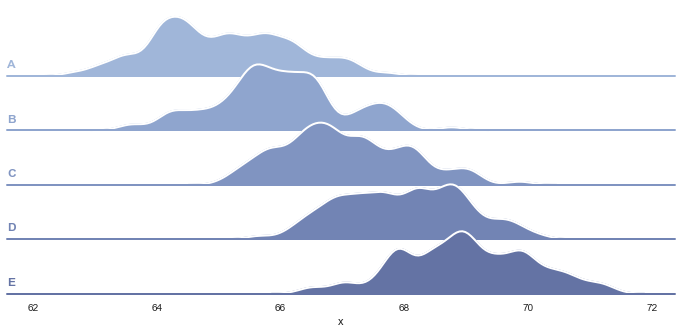

In [122]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
energy = np.tile(list("ABCDE"), 100)
df = pd.DataFrame(dict(x=x, energy=energy))
m = df.energy.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.1, light=.7)
g = sns.FacetGrid(df, row="energy", hue="energy", aspect=10, size=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.show()

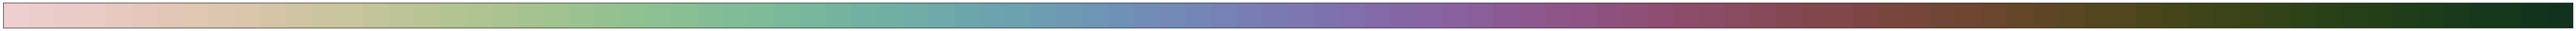

##### 